In [219]:
from PIL import Image
import numpy as np
import matplotlib; matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


In [301]:
class Correlator:
    
    def __init__(self):
        self.image = None
        self.filter = None

    def __padding(self, horizontal_padding, vertical_padding):
        padded_image = np.zeros((self.image.shape[0] + 2 * vertical_padding, self.image.shape[1] + 2 * horizontal_padding, 3))
        padded_image[vertical_padding : -vertical_padding, horizontal_padding : -horizontal_padding, :] = self.image 

        return padded_image
        
    def apply_correlation(self, image_path, filter_matrix, zero_padding = True, normalization = False):
        self.image = np.asarray(Image.open(image_path).convert('RGB'))
        self.filter = filter_matrix

        epsilon = 1e-7
        
        horizontal_padding = self.filter.shape[0]//2
        vertical_padding = self.filter.shape[1]//2

        if zero_padding:
            preprocessed_img = self.__padding(horizontal_padding, vertical_padding)
            output = np.zeros((self.image.shape[0], self.image.shape[1], 3))
        else:
            preprocessed_img = self.image
            output = np.zeros((self.image.shape[0] - 2 * vertical_padding, self.image.shape[1] - 2 * horizontal_padding, 3))

        if not normalization:
            for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
                for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                    for k in range(3):
                        output[i,j,k] = np.sum(np.multiply(self.filter, preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]))
        else:
            filter_diff = self.filter - np.mean(self.filter)
            normalized_filter = filter_diff/np.sum(np.abs(filter_diff + epsilon))
            if np.argmax(normalized_filter) == 0:
                print("Warning : Filter has mean zero. Normalization will result in a black image.")

            for i in range(preprocessed_img.shape[0] - self.filter.shape[0]):
                for j in range(preprocessed_img.shape[1] - self.filter.shape[1]):
                    for k in range(3):
                        window = preprocessed_img[i: i + self.filter.shape[0], j: j + self.filter.shape[1], k]
                        window_diff = window - np.mean(window)
                        output[i,j,k] = np.sum(np.multiply((window_diff)/np.sum(np.abs(window_diff + epsilon)), normalized_filter))
            
        return self.image, preprocessed_img, output

In [324]:
c = Correlator()

# filter_matrix = np.ones((9, 9), np.float32)/81
filter_matrix = np.array([[1]])

original, padded_image, output = c.apply_correlation("../app/assets/Imagens_teste/einstein.png", filter_matrix, zero_padding=False, normalization = False)

IndexError: index 352 is out of bounds for axis 0 with size 352

In [318]:
print(original.shape)
print(padded_image.shape)
print(output.shape)

(354, 361, 3)
(354, 361, 3)
(354, 361, 3)


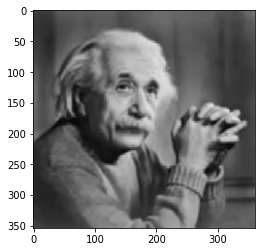

In [319]:
plt.imshow(original.astype(int))

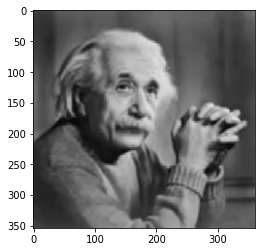

In [320]:
plt.imshow(padded_image.astype(int))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


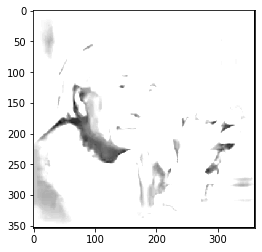

In [321]:
plt.imshow(output.astype(int))

In [283]:
import cv2

In [284]:
image = cv2.imread("../app/assets/Imagens_teste/einstein.png")

In [285]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

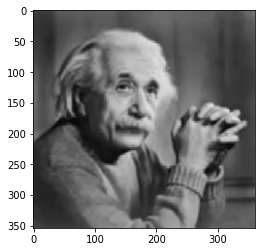

In [286]:
plt.imshow(image)

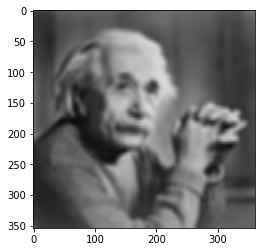

In [287]:
kernel_blur = np.ones((9, 9), np.float32)/81

blurred = cv2.filter2D(image, -1, kernel_blur)
plt.imshow(blurred)

In [288]:
blurred.shape

(354, 361, 3)

In [267]:
blurred[10:12,10:12,0]

array([[54, 54],
       [54, 54]], dtype=uint8)

In [268]:
np.round(output[10:12,10:12,0]).astype("uint8")

array([[54, 54],
       [54, 54]], dtype=uint8)

In [263]:
blurred.shape

(354, 361, 3)

In [264]:
output.shape

(354, 361, 3)